In [218]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import os
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [219]:
Nat_Gas = os.path.join(os.path.expanduser("~"), "Desktop", "Natural_Gas_monthly.csv")
df = pd.read_csv(Nat_Gas)
df = df.set_index('Month')


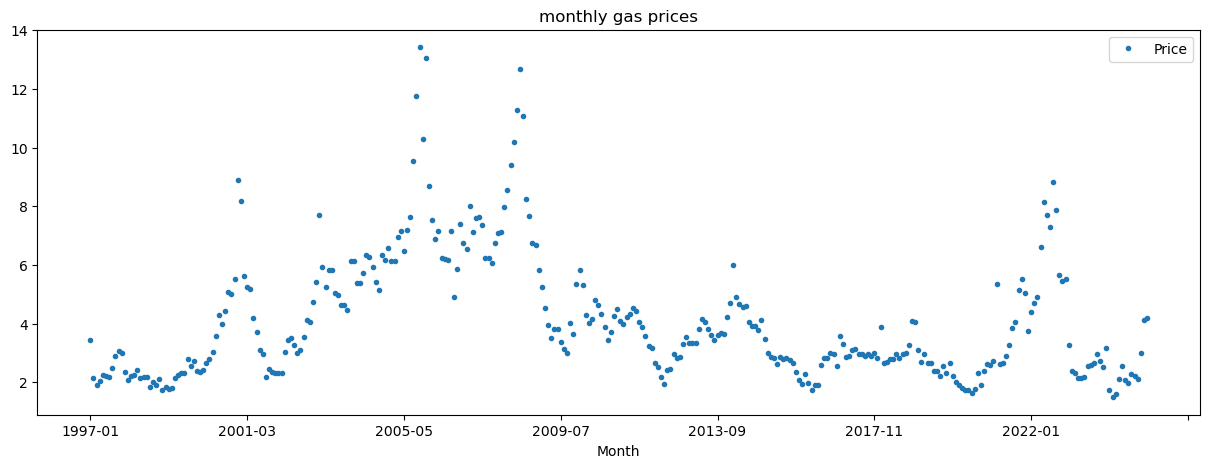

In [220]:
 df.plot(style='.',
        figsize=(15, 5),
        title='monthly gas prices')
plt.show()

In [221]:
df.index = pd.DatetimeIndex(df.index).to_period('M')
df.dtypes

Price    float64
dtype: object

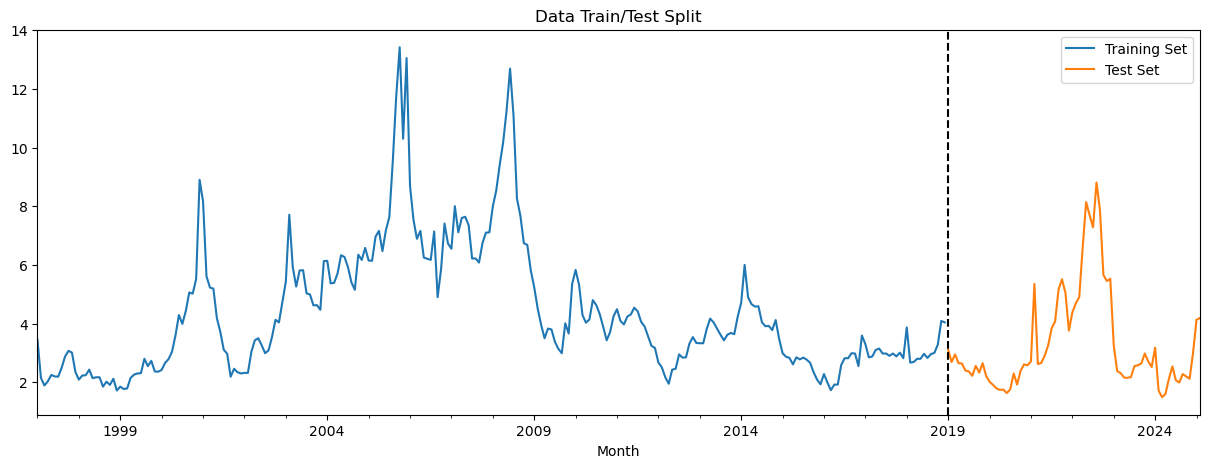

In [222]:
train = df.loc[df.index < '01-01-2019']
test = df.loc[df.index >= '01-01-2019']
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

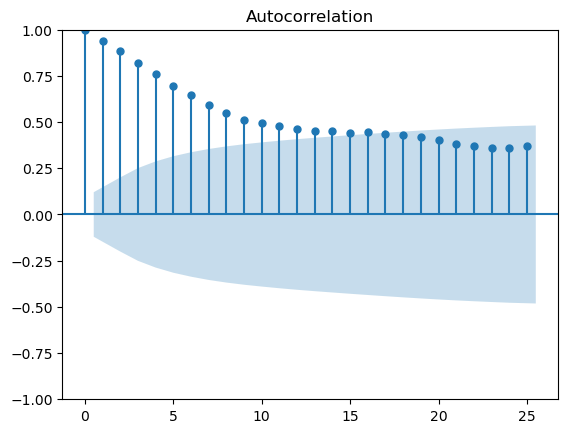

In [223]:
#Stationarity
acf = plot_acf(train)

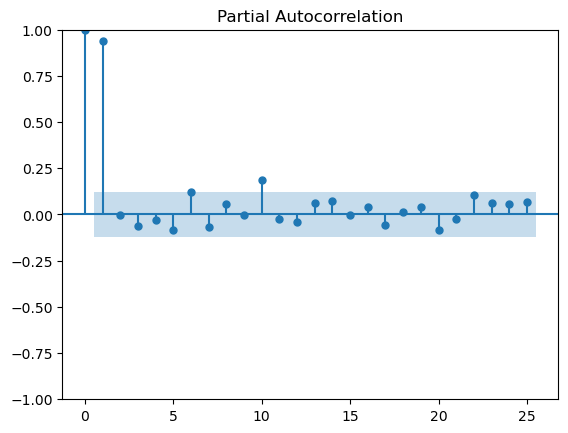

In [224]:
pacf = plot_pacf(train)

In [225]:
adf_test = adfuller(train)
print(f'p-value: {adf_test[1]}')

p-value: 0.05042846917384099


<Axes: xlabel='Month'>

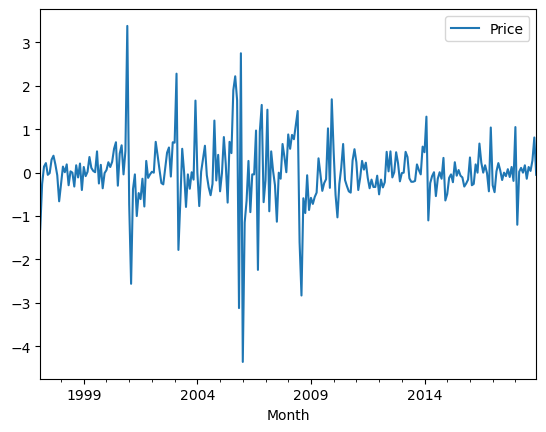

In [226]:
train_differenced = train.diff().dropna()
train_differenced.plot()

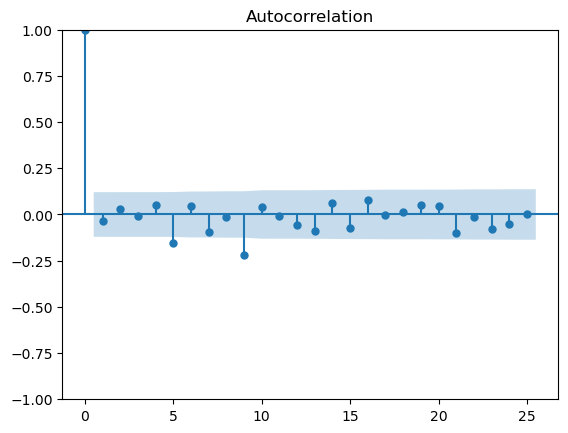

In [227]:
acf = plot_acf(train_differenced)

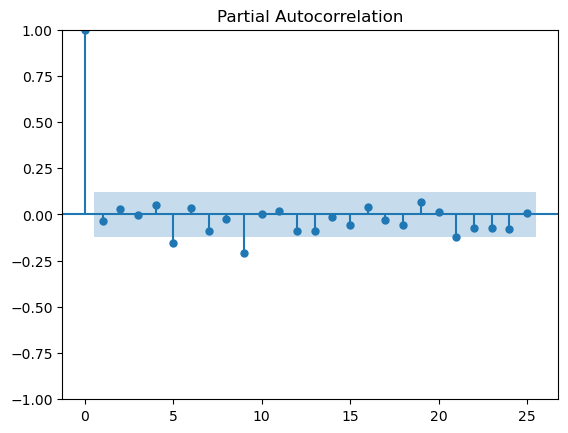

In [228]:
pacf = plot_pacf(train_differenced)

In [229]:
adf_test2 = adfuller(train_differenced)
print(f'p-value: {adf_test2[1]}')

p-value: 1.817322687346958e-10


In [230]:
#Following the first order differencing we can conclude the data is stationary thus: 
# Arima(p,1,q)

In [233]:
model = ARIMA(train, order=(2,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  264
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -299.014
Date:                Sat, 29 Mar 2025   AIC                            606.028
Time:                        14:34:58   BIC                            620.331
Sample:                    01-31-1997   HQIC                           611.775
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2913      1.143      3.756      0.000       2.052       6.531
ar.L1          0.9333      0.034     27.410      0.000       0.867       1.000
ar.L2          0.0037      0.033      0.111      0.9

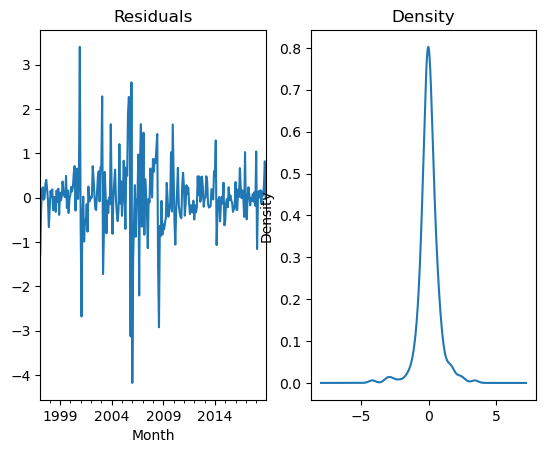

In [232]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title = 'Residuals', ax = ax[0])
residuals.plot(title = 'Density', kind = 'kde', ax = ax[1])
plt.show()

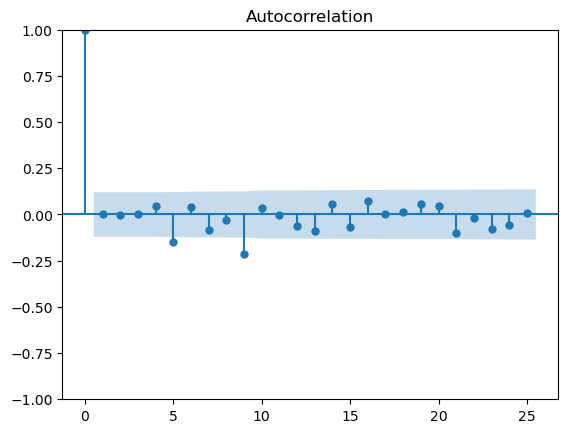

In [207]:
acf = plot_acf(residuals)

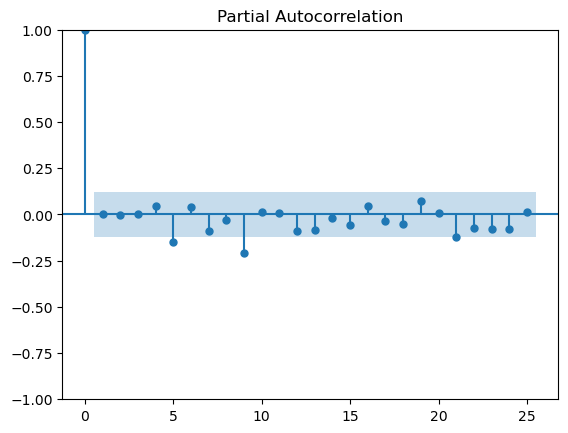

In [208]:
pacf = plot_pacf(residuals)

<Axes: xlabel='Month'>

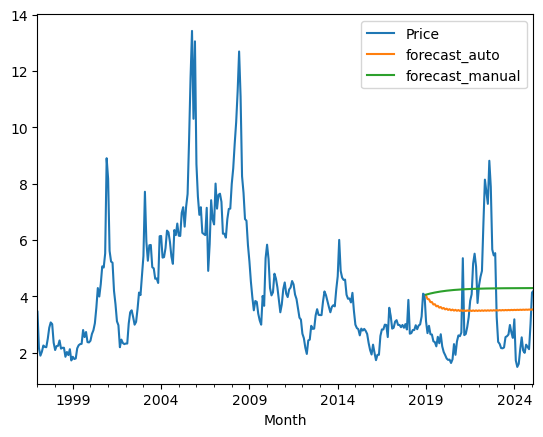

In [241]:
forecast_test = model_fit.forecast(len(test))
df['forecast_manual'] = [None]*len(train) + list(forecast_test)
df.plot()

In [242]:
auto_arima = pm.auto_arima(train, stepwise = False, seasonal = False)
auto_arima

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [243]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  264
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -294.634
Date:                Sat, 29 Mar 2025   AIC                            603.268
Time:                        14:35:33   BIC                            628.273
Sample:                    01-31-1997   HQIC                           613.317
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.006      0.042      0.966      -0.012       0.013
ar.L1         -0.0022      0.068     -0.032      0.974      -0.136       0.132
ar.L2          0.8591      0.069     12.368      0.000       0.723       0.995
ar.L3         -0.0828      0.049     -1.702      0.089      -0.178       0.013
ma.L1         -0.0238      0.059     -0.402      0.688      -0.140       0.092
ma.L2         -0.8887      0.072    -12.384      0.000      -1.029      -0.748
sigma2         0.5479      0.027     20.483      0.000       0.495       0.600
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               452.32
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

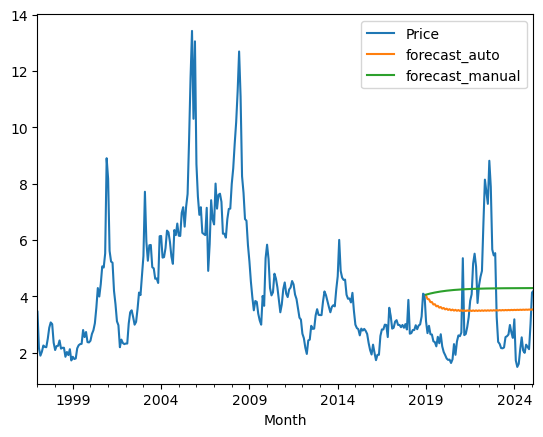

In [244]:
forecast_test_auto = auto_arima.predict(n_periods=len(test))
df['forecast_auto'] = [None]*len(train) + list(forecast_test_auto)
df.plot()

In [247]:
mae = mean_absolute_error(test, forecast_test)
mape = mean_absolute_percentage_error(test, forecast_test)
rmse = np.sqrt(mean_squared_error(test, forecast_test))

print(f'mae - manual: {mae}')
print(f'mape - manual: {mape}')
print(f'rmse - manual: {rmse}')

mae - manual: 1.7455054038640225
mape - manual: 0.6678831041568263
rmse - manual: 1.9346436630473511


In [248]:
mae = mean_absolute_error(test, forecast_test_auto)
mape = mean_absolute_percentage_error(test, forecast_test_auto)
rmse = np.sqrt(mean_squared_error(test, forecast_test_auto))

print(f'mae - auto: {mae}')
print(f'mape - auto: {mape}')
print(f'rmse - auto: {rmse}')

mae - auto: 1.4526560811050664
mape - auto: 0.49004221919873475
rmse - auto: 1.7465320504553907


In [215]:
train.shape

(264, 1)

In [176]:
test.shape

(74, 1)